In [3]:
#imports and data
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import mean_squared_error
from xgboost import XGBRegressor

sns.set(style="whitegrid", context="talk")

def rmse(y_true, y_pred):
    """Root Mean Squared Error (RMSE) – unabhängig von sklearn-Version."""
    return np.sqrt(mean_squared_error(y_true, y_pred))

df = pd.read_csv("../data/processed/data_for_model_engineered.csv")
df["Datum"] = pd.to_datetime(df["Datum"])
df = df.sort_values("Datum").reset_index(drop=True)

df[["Datum", "Standort_ID", "Velo"]].head()



,Datum,Standort_ID,Velo
0,2022-01-01,60,134.0
1,2022-01-01,1037,1141.0
2,2022-01-01,4241,383.0
3,2022-01-01,3927,497.0
4,2022-01-01,3598,562.0


In [4]:
# Definition of feature and target

TARGET = "Velo"

exclude = [
    "Velo",
    "Velo_log",       # nur falls vorhanden
    "Datum",          # rohes Datum nicht direkt ins Modell
    "Standort_ID",
    "Koord_Ost",
    "Koord_Nord",
    "year",
    "week",
    "quarter",
    # "day_of_year",
    "year_length",
]

features = [c for c in df.columns if c not in exclude]

X = df[features]
y = df[TARGET]
dates = df["Datum"]

X.shape, y.shape, len(features), features[:10]

((23799, 19),
 (23799,),
 19,
 ['day_of_year',
  'Niederschlag',
  'Temperatur Durchschnitt',
  'weekday',
  'weekend',
  'is_holiday',
  'month',
  'sin_day',
  'cos_day',
  'temp_feels'])

In [5]:
df["Datum"].min(), df["Datum"].max()

(Timestamp('2022-01-01 00:00:00'), Timestamp('2024-12-31 00:00:00'))

In [6]:
cutoff_date = pd.to_datetime("2024-01-01")

train_idx = dates < cutoff_date
test_idx  = dates >= cutoff_date

X_train, X_test = X[train_idx], X[test_idx]
y_train, y_test = y[train_idx], y[test_idx]

print("Train samples:", X_train.shape[0])
print("Test samples:", X_test.shape[0])


Train samples: 15286
Test samples: 8513


In [7]:
model = XGBRegressor(
    n_estimators=400,
    max_depth=8,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    objective="reg:squarederror",
    random_state=42,
    n_jobs=-1,
)

model.fit(X_train, y_train)

y_pred_2024 = model.predict(X_test)


In [8]:
rmse_2024 = rmse(y_test, y_pred_2024)
print("RMSE 2024:", rmse_2024)

mae_2024 = np.mean(np.abs(y_test - y_pred_2024))
print("MAE 2024: ", mae_2024)


RMSE 2024: 238.5371757487926
MAE 2024:  150.84228737357358


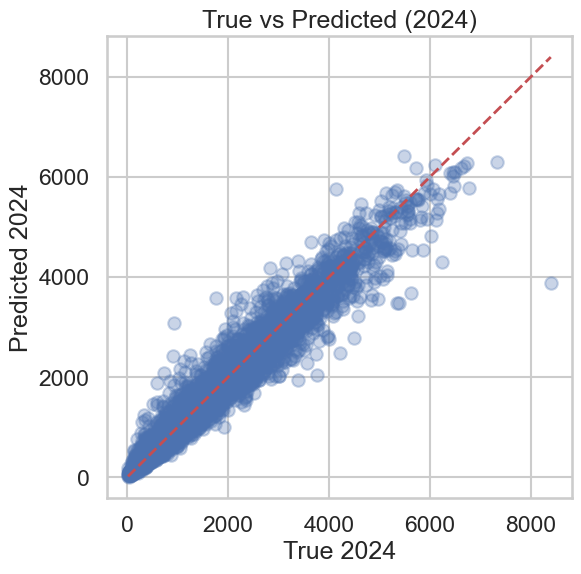

In [9]:
plt.figure(figsize=(6,6))
plt.scatter(y_test, y_pred_2024, alpha=0.3)
plt.plot([y_test.min(), y_test.max()], 
         [y_test.min(), y_test.max()], 
         "r--", linewidth=2)
plt.xlabel("True 2024")
plt.ylabel("Predicted 2024")
plt.title("True vs Predicted (2024)")
plt.show()


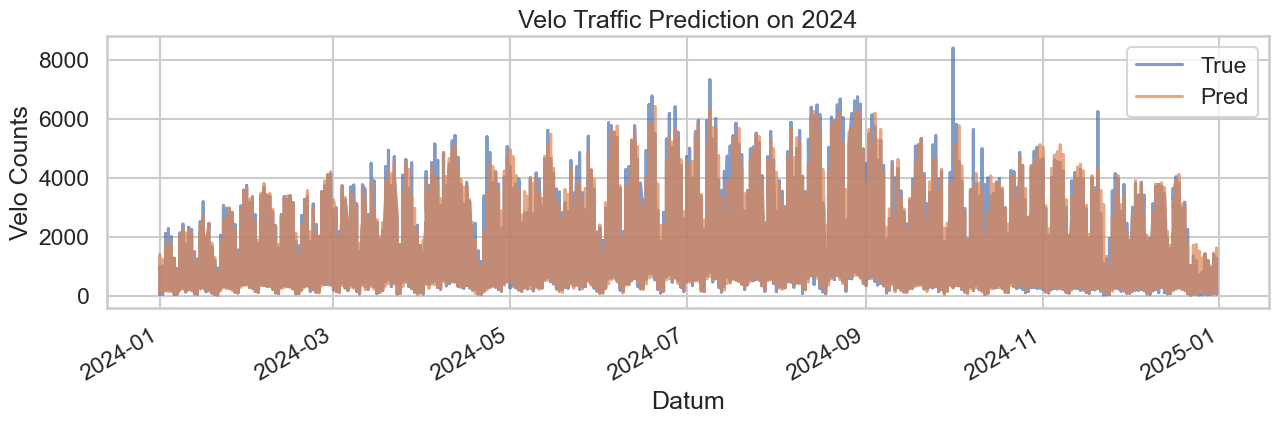

In [12]:
temp = pd.DataFrame({
    "Datum": dates[test_idx],
    "True": y_test.values,
    "Pred": y_pred_2024
}).set_index("Datum")

temp[["True", "Pred"]].plot(figsize=(15,4), alpha=0.7)
plt.title("Velo Traffic Prediction on 2024")
plt.ylabel("Velo Counts")
plt.show()


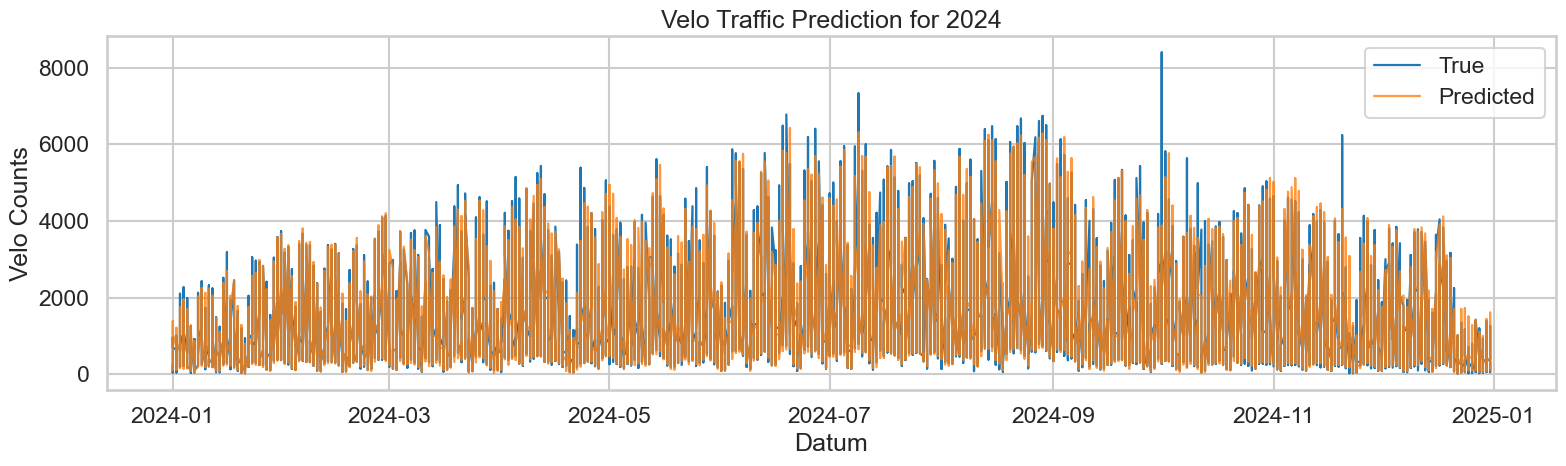

In [13]:
plt.figure(figsize=(16,5))

plt.plot(temp.index, temp["True"], 
         label="True", color="#1f77b4", linewidth=1.6)

plt.plot(temp.index, temp["Pred"], 
         label="Predicted", color="#ff7f0e", linewidth=1.6, alpha=0.8)

plt.title("Velo Traffic Prediction for 2024")
plt.ylabel("Velo Counts")
plt.xlabel("Datum")
plt.legend()
plt.tight_layout()
plt.show()


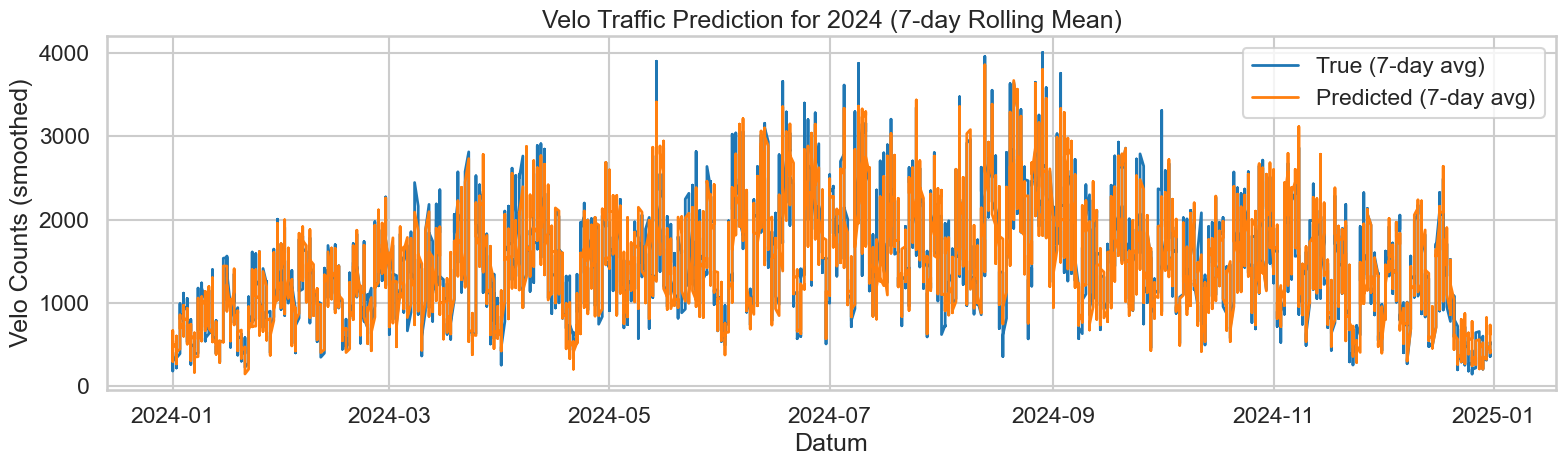

In [14]:
plt.figure(figsize=(16,5))

plt.plot(temp.index, temp["True"].rolling(7).mean(), 
         label="True (7-day avg)", color="#1f77b4", linewidth=2)

plt.plot(temp.index, temp["Pred"].rolling(7).mean(), 
         label="Predicted (7-day avg)", color="#ff7f0e", linewidth=2)

plt.title("Velo Traffic Prediction for 2024 (7-day Rolling Mean)")
plt.ylabel("Velo Counts (smoothed)")
plt.xlabel("Datum")
plt.legend()
plt.tight_layout()
plt.show()



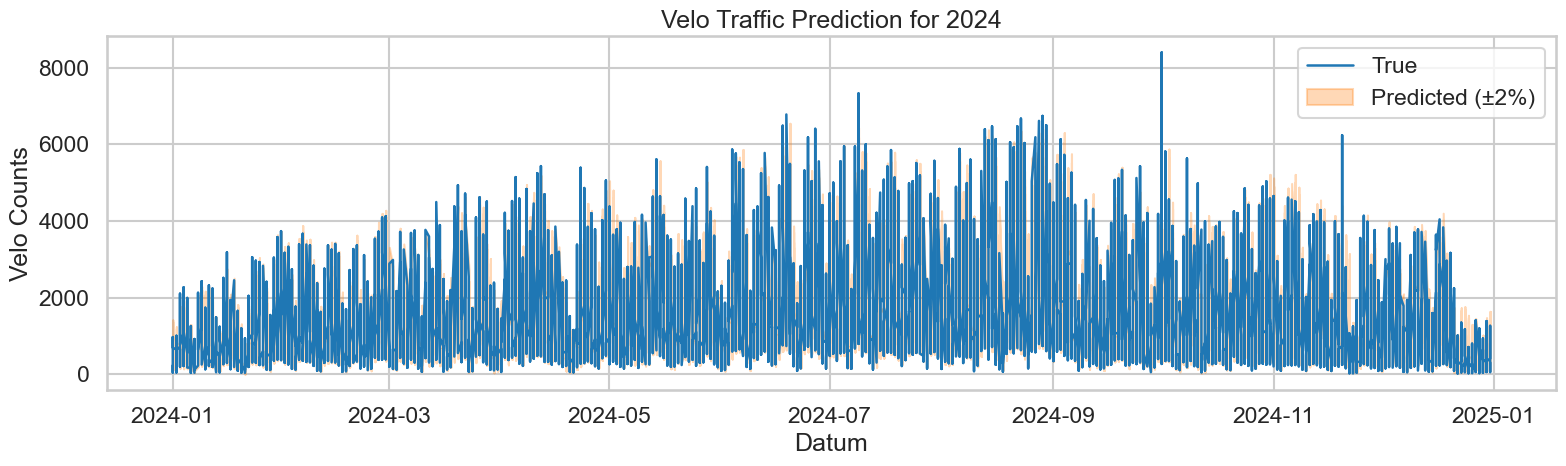

In [15]:
plt.figure(figsize=(16,5))

plt.plot(temp.index, temp["True"], 
         label="True", color="#1f77b4", linewidth=1.8)

plt.fill_between(temp.index, temp["Pred"]*0.98, temp["Pred"]*1.02, 
                 color="#ff7f0e", alpha=0.3, label="Predicted (±2%)")

plt.title("Velo Traffic Prediction for 2024")
plt.ylabel("Velo Counts")
plt.xlabel("Datum")
plt.legend()
plt.tight_layout()
plt.show()
